In [3]:
import warnings
warnings.filterwarnings('ignore')

import duckdb
from typing_extensions import TypedDict
from typing import List, Annotated
from IPython.display import display, HTML, Image
import matplotlib.pyplot as plt
import io
import base64

# Importações dos módulos do LangGraph
from langchain_ollama import OllamaLLM
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables.graph import MermaidDrawMethod
from operator import add

In [4]:
# Definir o modelo de linguagem
ollama_llm = OllamaLLM(
    model="gemma2:2b",
    base_url="http://localhost:11434",
)

In [5]:
# Definir o estado do agente usando TypedDict
class AgentState(TypedDict):
    question: str
    table_schemas: str
    database: str
    sql: str
    reflect: Annotated[List[str], add]
    accepted: bool
    revision: int
    max_revision: int
    results: List[tuple]
    interpretation: str
    plot_needed: bool
    plot_html: str

# Função para obter o esquema do banco de dados
def get_database_schema(db_path):
    conn = duckdb.connect(db_path)
    cursor = conn.cursor()
    cursor.execute("SELECT table_name FROM information_schema.tables WHERE table_schema='main'")
    tables = cursor.fetchall()
    schema = ''
    for table_name in tables:
        table_name = table_name[0]
        cursor.execute(f"DESCRIBE {table_name}")
        columns = cursor.fetchall()
        schema += f"Tabela: {table_name}\n"
        schema += "Colunas:\n"
        for column in columns:
            schema += f" - {column[0]} ({column[1]})\n"
        schema += '\n'
    conn.close()

    print('################ schema ################')
    print(schema)
    return schema

# Definir os nós para o LangGraph
def search_engineer_node(state: AgentState):
    db_schema = get_database_schema('clientes_novo.duckdb')
    state['table_schemas'] = db_schema
    state['database'] = 'clientes_novo.duckdb'
    return state

def sql_writer_node(state: AgentState):
    role_prompt = """
Você é um especialista em DuckDB e sua sintaxe SQL. Sua tarefa é escrever **apenas** a consulta SQL que responda à pergunta do usuário. A consulta deve:

- Usar a sintaxe SQL do DuckDB padrão em inglês.
- Utilizar os nomes das tabelas e colunas conforme definidos no esquema do banco de dados.
- Não incluir comentários, explicações ou qualquer texto adicional.
- Não utilizar formatação de código ou markdown.
- Retornar apenas a consulta SQL válida.
"""
    instruction = f"Esquema do banco de dados:\n{state['table_schemas']}\n"
    if len(state['reflect']) > 0:
        instruction += f"Considere os seguintes feedbacks:\n{chr(10).join(state['reflect'])}\n"
    instruction += f"Escreva a consulta SQL que responda à seguinte pergunta: {state['question']}\n"
    prompt = f"{role_prompt}\n{instruction}"
    response = ollama_llm.generate([prompt]).generations[0][0].text
    state['sql'] = response.strip()
    state['revision'] += 1
    return state

def qa_engineer_node(state: AgentState):
    role_prompt = """
Você é um engenheiro de QA especializado no banco relacional DuckDB e sua sintaxe SQL. Sua tarefa é verificar se a consulta SQL fornecida responde corretamente à pergunta do usuário.
"""
    instruction = f"Com base no seguinte esquema de banco de dados:\n{state['table_schemas']}\n"
    instruction += f"E na seguinte consulta SQL:\n{state['sql']}\n"
    instruction += f"Verifique se a consulta SQL pode completar a tarefa: {state['question']}\n"
    instruction += "Responda 'ACEITO' se estiver correta ou 'REJEITADO' se não estiver.\n"
    prompt = f"{role_prompt}\n{instruction}"
    response = ollama_llm.generate([prompt]).generations[0][0].text
    state['accepted'] = 'ACEITO' in response.upper()
    return state

def chief_dba_node(state: AgentState):
    role_prompt = """
Você é um DBA experiente, especialista em DuckDB. Sua tarefa é fornecer feedback detalhado para melhorar a consulta SQL fornecida.
"""
    instruction = f"Com base no seguinte esquema de banco de dados:\n{state['table_schemas']}\n"
    instruction += f"E na seguinte consulta SQL:\n{state['sql']}\n"
    instruction += f"Por favor, forneça recomendações úteis e detalhadas para ajudar a melhorar a consulta SQL para a tarefa: {state['question']}\n"
    prompt = f"{role_prompt}\n{instruction}"
    response = ollama_llm.generate([prompt]).generations[0][0].text
    state['reflect'].append(response)
    return state

def execute_query_node(state: AgentState):
    conn = duckdb.connect(state['database'])
    cursor = conn.cursor()
    try:
        cursor.execute(state['sql'])
        state['results'] = cursor.fetchall()
    except Exception as e:
        state['results'] = []
        state['error'] = str(e)
    finally:
        cursor.close()
        conn.close()
    return state

def interpret_results_node(state: AgentState):
    role_prompt = """
Você é um assistente especializado em interpretar resultados de consultas SQL comn a sintaxe do DuckDB, explicá-los em linguagem natural e sugerir visualizações apropriadas. Evite sugerir gráficos quando o resultado for um único valor.
Sua tarefa é analisar os resultados da consulta, fornecer uma resposta clara e concisa à pergunta original do usuário e sugerir um tipo de gráfico adequado se houver dados numéricos para comparar com outras unidades, locais, clientes, etc.
"""
    instruction = f"Pergunta original: {state['question']}\n"
    instruction += f"Consulta SQL executada: {state['sql']}\n"
    instruction += f"Resultados da consulta: {state['results']}\n"
    instruction += "Por favor, interprete esses resultados, responda à pergunta original em linguagem natural e sugira um tipo de gráfico adequado se aplicável, especialmente quando houver dados numéricos e comparações.Se a resposta for tipo O maior ou o mais caro, indicando unidade máxima, evite plotar gráficos"
    prompt = f"{role_prompt}\n{instruction}"
    response = ollama_llm.generate([prompt]).generations[0][0].text
    state['interpretation'] = response
    # Decidir se um gráfico é necessário com base na interpretação
    if "gráfico" in response.lower() or "gráfico" in response.lower():
        state['plot_needed'] = True
    else:
        state['plot_needed'] = False
    return state

def plot_results_node(state: AgentState):
    if not state['plot_needed']:
        state['plot_html'] = ''
        return state
    # Gerar o gráfico
    results = state['results']
    if not results or len(results) == 0:
        state['plot_html'] = ''
        return state
    # Assumindo que a primeira coluna são rótulos e a última coluna são valores
    labels = [str(row[0]) for row in results]
    values = [row[-1] if isinstance(row[-1], (int, float)) else 0 for row in results]
    plt.figure(figsize=(10, 6))
    # Determinar o tipo de gráfico com base na sugestão
    if "barra" in state['interpretation'].lower():
        plt.bar(labels, values)
    elif "pizza" in state['interpretation'].lower():
        plt.pie(values, labels=labels, autopct='%1.1f%%')
    else:  # padrão para gráfico de linhas
        plt.plot(labels, values, marker='o')
    plt.title(state['question'])
    plt.xlabel('Categorias')
    plt.ylabel('Valores')
    plt.xticks(rotation=45)
    plt.tight_layout()
    # Salvar o gráfico em um buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close()
    # Converter o gráfico para base64
    img_base64 = base64.b64encode(buf.getvalue()).decode('utf-8')
    # Criar HTML para exibir o gráfico
    img_html = f'<img src="data:image/png;base64,{img_base64}">'
    state['plot_html'] = img_html
    return state

In [6]:
# Construir o LangGraph
builder = StateGraph(AgentState)

# Adicionar nós ao grafo
builder.add_node('search_engineer', search_engineer_node)
builder.add_node('sql_writer', sql_writer_node)
builder.add_node('qa_engineer', qa_engineer_node)
builder.add_node('chief_dba', chief_dba_node)
builder.add_node('execute_query', execute_query_node)
builder.add_node('interpret_results', interpret_results_node)
builder.add_node('plot_results', plot_results_node)

# Definir as arestas entre os nós
builder.add_edge(START, 'search_engineer')
builder.add_edge('search_engineer', 'sql_writer')
builder.add_edge('sql_writer', 'qa_engineer')

# Aresta condicional do qa_engineer
builder.add_conditional_edges(
    'qa_engineer',
    lambda state: 'execute_query' if state['accepted'] or state['revision'] >= state['max_revision'] else 'chief_dba',
    {'execute_query': 'execute_query', 'chief_dba': 'chief_dba'}
)

builder.add_edge('chief_dba', 'sql_writer')
builder.add_edge('execute_query', 'interpret_results')
builder.add_edge('interpret_results', 'plot_results')
builder.add_edge('plot_results', END)

# Definir o ponto de entrada
builder.set_entry_point('search_engineer')

In [7]:
# Compilar o grafo com um checkpointer
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

# Função para processar uma pergunta usando o grafo
def process_question(question):
    initial_state = {
        'question': question,
        'table_schemas': '',
        'database': '',
        'sql': '',
        'reflect': [],
        'accepted': False,
        'revision': 0,
        'max_revision': 2,
        'results': [],
        'interpretation': '',
        'plot_needed': False,
        'plot_html': ''
    }
    thread = {'configurable': {'thread_id': '1'}}
    for s in graph.stream(initial_state, thread):
        pass
    # Obter o estado final
    final_state = graph.get_state(thread).values

    # Imprimir os resultados
    print('Consulta SQL Gerada:\n', final_state['sql'])
    print('\nResultados da Consulta:')
    if 'results' in final_state:
        for result in final_state['results']:
            print(result)
    else:
        print('Nenhum resultado')
    print('\nInterpretação:')
    print(final_state['interpretation'])
    if final_state.get('plot_html'):
        display(HTML(final_state['plot_html']))
    else:
        print('Nenhum gráfico gerado.')

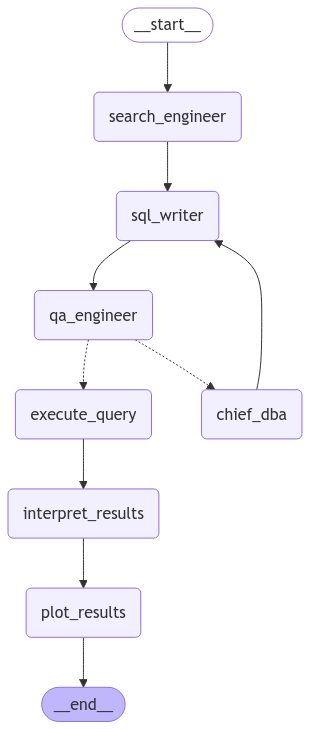

In [8]:
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [9]:
pergunta = "Qual é a distribuição de produtos entre os clientes que pagam acima da média geral?"
process_question(pergunta)

################ schema ################
Tabela: clientes
Colunas:
 - cliente_id (INTEGER)
 - nome (VARCHAR)
 - sobrenome (VARCHAR)
 - email (VARCHAR)
 - produto (VARCHAR)
 - plano (VARCHAR)
 - valor_pago (DECIMAL(10,2))


Consulta SQL Gerada:
 ```sql
SELECT produto, SUM(valor_pago) AS total_payment 
FROM clientes
GROUP BY produto
HAVING SUM(valor_pago) > (SELECT AVG(valor_pago) FROM clientes);
```

Resultados da Consulta:

Interpretação:
A consulta SQL retorna uma lista de produtos e seu total de pagamento por cada cliente, agrupados em base no produto. A partir do cálculo de `SUM(valor_pago)`, a query selecionou os clientes que pagaram acima da média geral. 

**Resultado:** O resultado mostra os produtos mais caros (com o maior valor pago) dos clientes que superam a média de pagamento geral. 


**Sugestão de gráfico:** Se houver dados numéricos para comparar com outras unidades, locais, clientes, etc., um **gráfico de barras ou de histogramas** seria útil para visualizar essa compara

In [ ]:
pergunta = "Qual é o produto mais popular entre os clientes que possuem plano anual?"
process_question(pergunta)

In [ ]:
pergunta = "Faça um gráfico de pizza dos produtos mais vendidos"
process_question(pergunta)